In [5]:
import pandas as pd

file_path = 'SLC_all_param.csv'
df = pd.read_csv(file_path)

Top 5 features and their correlation with the target variable:
total_precipitation (mm of water equivalent): 0.66
surface_pressure (Pa): 0.32
total_cloud_cover (0-1): 0.27
relative_humidity (0-1): 0.27
volumetric_soil_water_layer_1 (0-1): 0.21


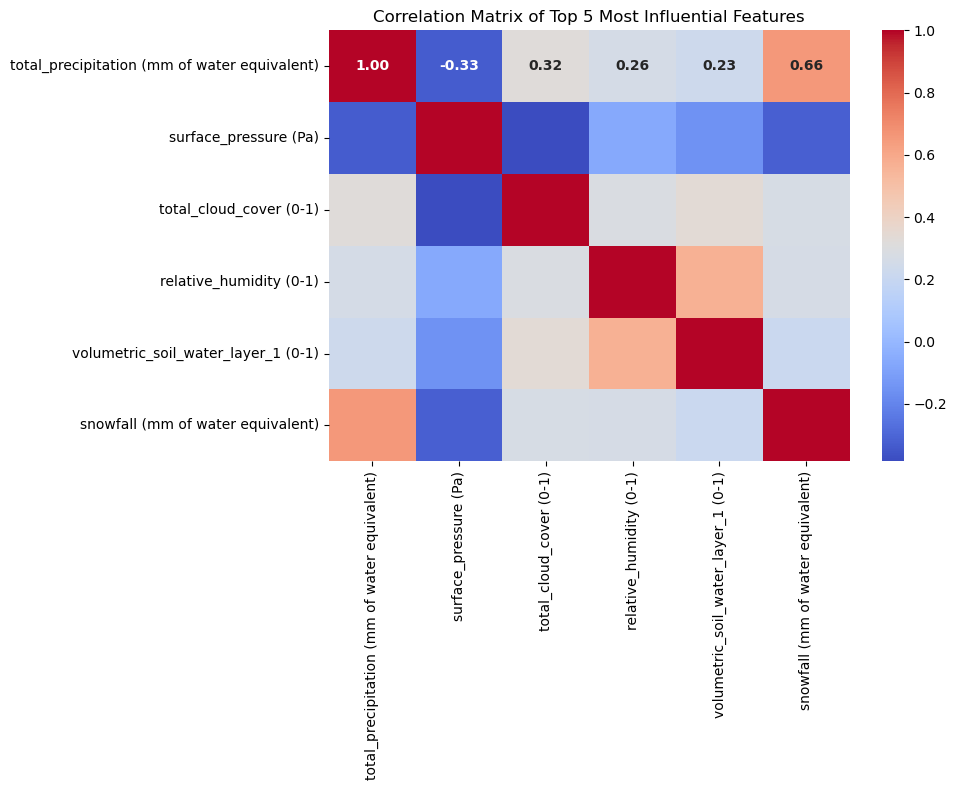

In [6]:
#Preprocessing for all features

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Parse datetime and split coordinates
df['datetime (UTC)'] = pd.to_datetime(df['datetime (UTC)'])
df[['latitude', 'longitude']] = df['coordinates (lat,lon)'].str.extract(r'\(([^,]+), ([^)]+)\)').astype(float)

# Drop columns with 50% or more null values
df = df.dropna(thresh=len(df) * 0.7, axis=1)

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['model (name)'])

# break down the UTC t from datetime
df_encoded['hour'] = df_encoded['datetime (UTC)'].dt.hour
df_encoded['day'] = df_encoded['datetime (UTC)'].dt.day
df_encoded['month'] = df_encoded['datetime (UTC)'].dt.month

# Drop the original datetime and coordinates columns
df_encoded.drop(['datetime (UTC)', 'coordinates (lat,lon)'], axis=1, inplace=True)

# Check if df_encoded is empty
#  print(df_encoded.head())

# Scaling numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_encoded.select_dtypes(include=['float64', 'int64']))  # Scale only numerical features
df_scaled = pd.DataFrame(scaled_features, columns=df_encoded.select_dtypes(include=['float64', 'int64']).columns)
df_encoded[df_scaled.columns] = df_scaled

# Calculate correlation with target variable
correlation_with_target = df_encoded.corr()['snowfall (mm of water equivalent)'].abs()

# Select top 5 most influential features (excluding the target variable)
top_5_features = correlation_with_target.sort_values(ascending=False).index[1:6]

print("Top 5 features and their correlation with the target variable:")
for feature in top_5_features:
    correlation_value = correlation_with_target[feature]
    print(f"{feature}: {correlation_value:.2f}")

# Create correlation matrix using only the top 5 features and the target variable
correlation_matrix = df_encoded[top_5_features].join(df_encoded['snowfall (mm of water equivalent)']).corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"fontsize":10, "weight": "bold"})
plt.title("Correlation Matrix of Top 5 Most Influential Features")
plt.tight_layout()
plt.show()

In [7]:
top_10_features = correlation_with_target.sort_values(ascending=False).index[1:11]

# Print top 10 features and their correlation values
print("Top 10 features and their correlation with the target variable:")
for feature in top_10_features:
    correlation_value = correlation_with_target[feature]
    print(f"{feature}: {correlation_value:.2f}")

Top 10 features and their correlation with the target variable:
total_precipitation (mm of water equivalent): 0.66
surface_pressure (Pa): 0.32
total_cloud_cover (0-1): 0.27
relative_humidity (0-1): 0.27
volumetric_soil_water_layer_1 (0-1): 0.21
heating_degreeday (degC-Day): 0.20
soil_temperature_level_2 (degC): 0.20
snow_depth (mm of water equivalent): 0.20
soil_temperature_level_1 (degC): 0.20
temperature (degC): 0.20


In [18]:
# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Parse datetime and split coordinates
df['datetime (UTC)'] = pd.to_datetime(df['datetime (UTC)'])

# Select features and target variable
features = ['temperature (degC)', 'relative_humidity (0-1)', 'total_precipitation (mm of water equivalent)', 'total_cloud_cover (0-1)']
target_variable = 'snowfall (mm of water equivalent)'

data = df[['datetime (UTC)', target_variable] + features].copy()

data['hour'] = data['datetime (UTC)'].dt.hour
data['day'] = data['datetime (UTC)'].dt.day
data['month'] = data['datetime (UTC)'].dt.month
data['year'] = data['datetime (UTC)'].dt.year

data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data.set_index('date', inplace=True)

# Drop the original datetime and coordinates columns
data.drop(['datetime (UTC)'], axis=1, inplace=True)

print(len(data))

263016


In [32]:
filtered_data = data[(data['hour'] == 10) & (data['month'] == 2)]

# Create a DataFrame from the filtered data
df = pd.DataFrame(filtered_data.copy())
df2 = df.copy()

snowfall_mean = df['snowfall (mm of water equivalent)'].mean()

print("Mean snowfall (mm of water equivalent) in febs (1994-2024):", snowfall_mean)

Mean snowfall (mm of water equivalent) in febs (1994-2024): 0.06596698113207547


In [31]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Assuming filtered_data contains the DataFrame you provided earlier

# Define the features and target variable
features = ['temperature (degC)', 'relative_humidity (0-1)', 'total_precipitation (mm of water equivalent)', 'total_cloud_cover (0-1)', 'date']
target_variable = 'snowfall (mm of water equivalent)'

# Recreate the index with a specific frequency (assuming daily frequency)
df.index = pd.date_range(start=df.index.min(), periods=len(df), freq='D')

# Fit autoregression model
model = AutoReg(df[target_variable], lags=1)  # Assuming lag order is 1
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start='2034-02-10', end='2034-02-10', dynamic=False)

print(predictions)

print(df.head())


2034-02-10    0.066045
Freq: D, dtype: float64
            snowfall (mm of water equivalent)  temperature (degC)  \
1995-02-01                                0.0                2.59   
1995-02-02                                0.0                2.37   
1995-02-03                                0.0               -1.82   
1995-02-04                                0.0               -1.53   
1995-02-05                                0.0               -1.93   

            relative_humidity (0-1)  \
1995-02-01                     0.88   
1995-02-02                     0.91   
1995-02-03                     0.83   
1995-02-04                     0.78   
1995-02-05                     0.74   

            total_precipitation (mm of water equivalent)  \
1995-02-01                                          0.01   
1995-02-02                                          0.02   
1995-02-03                                          0.00   
1995-02-04                                          0.00   
199

In [21]:
# Define the date for which you want to make the prediction
prediction_date = '2034-02-28'
prediction_date = '2034-02-28'
# Predict snowfall for the specified date
prediction = model_fit.predict(start=prediction_date, end=prediction_date)

print("Predicted snowfall on February 10, 2034:", prediction.values[0])


Predicted snowfall on February 10, 2034: 0.0660448642266824


In [46]:
# Calculate summary statistics from historical data
historical_mean = df['snowfall (mm of water equivalent)'].mean()
historical_std = df['snowfall (mm of water equivalent)'].std()

# Compare with predicted snowfall
predicted_snowfall = prediction.values[0]  # Your predicted snowfall value
significance_level = 0.95  # For example, use 95% confidence interval

# Calculate the upper and lower bounds of significance
upper_bound = historical_mean + significance_level * historical_std
lower_bound = historical_mean - significance_level * historical_std

print("Historic Mean:")
print(historical_mean)

print("Upper:")
print(upper_bound)
print("Lower:")
print(lower_bound)
print("Predicted:")
print(predicted_snowfall)


Historic Mean:
0.06596698113207547
Upper:
0.2586400511430493
Lower:
-0.12670608887889834
Predicted:
0.0660448642266824


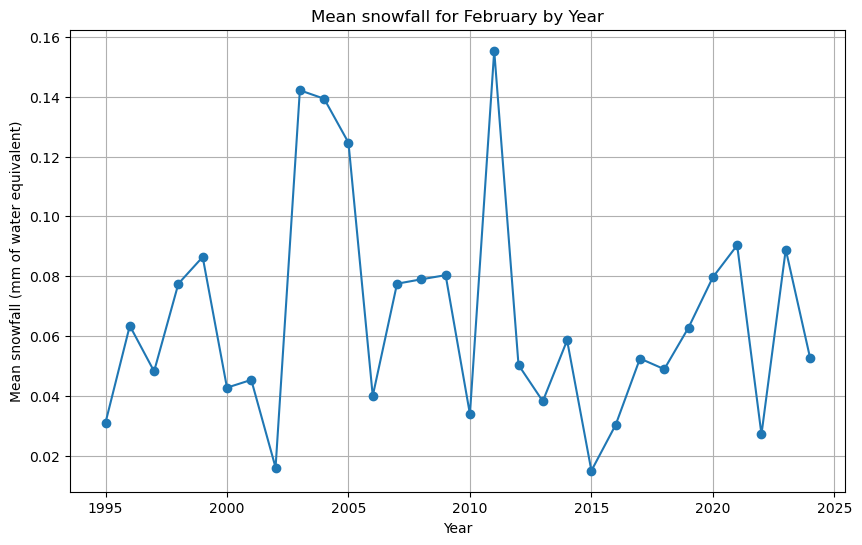

In [64]:
# Filter the data for February (month = 2)
february_data = df2[df2['month'] == 2]

# Group by year, calculate the mean
yearly_mean = february_data.groupby('year').mean()

# Reset index to make 'year' as a column
yearly_mean = yearly_mean.reset_index()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(yearly_mean['year'], yearly_mean['snowfall (mm of water equivalent)'], marker='o')

plt.title('Mean snowfall for February by Year')
plt.xlabel('Year')
plt.ylabel('Mean snowfall (mm of water equivalent)')
plt.grid(True)
plt.show()

In [65]:
# Find historical maximum and minimum snowfall values
historical_max = df2['snowfall (mm of water equivalent)'].max()
historical_min = df2['snowfall (mm of water equivalent)'].min()

# Find dates corresponding to the maximum and minimum snowfall values
date_max = df2[df2['snowfall (mm of water equivalent)'] == historical_max].index[0]
date_min = df2[df2['snowfall (mm of water equivalent)'] == historical_min].index[0]

# Print the maximum and minimum values along with their corresponding dates
print("Historical Maximum Snowfall:", historical_max, "mm")
print("Date of Maximum Snowfall:", date_max)
print("Historical Minimum Snowfall:", historical_min, "mm")
print("Date of Minimum Snowfall:", date_min)

Historical Maximum Snowfall: 2.88 mm
Date of Maximum Snowfall: 2003-02-02 00:00:00
Historical Minimum Snowfall: 0.0 mm
Date of Minimum Snowfall: 1995-02-01 00:00:00
